# Analysing A subset of data from "Ultra-high throughput mapping of genetic design space"

***--- Python version ---***


import packages

In [1]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wimpy import wimpy as wp

%load_ext autoreload
%autoreload 2


*Optional - just to make tqdm progress bar look better in vscode dark mode*

In [2]:
%%html
<style>
    .cell-output-ipywidget-background {
        background-color: transparent !important;
    }

    :root {
        --jp-widgets-color: var(--vscode-editor-foreground);
        --jp-widgets-font-size: var(--vscode-editor-font-size);
    }
</style>

## About the dataset

In the example script, we analyze a subset of the Nanopore sequencing data from the [CLASSIC](https://www.biorxiv.org/content/10.1101/2023.03.16.532704v2) 166k-member library. The library consists of two genes, one expressing a synthetic transcription factor (SynTF), and the other a GFP reporter:

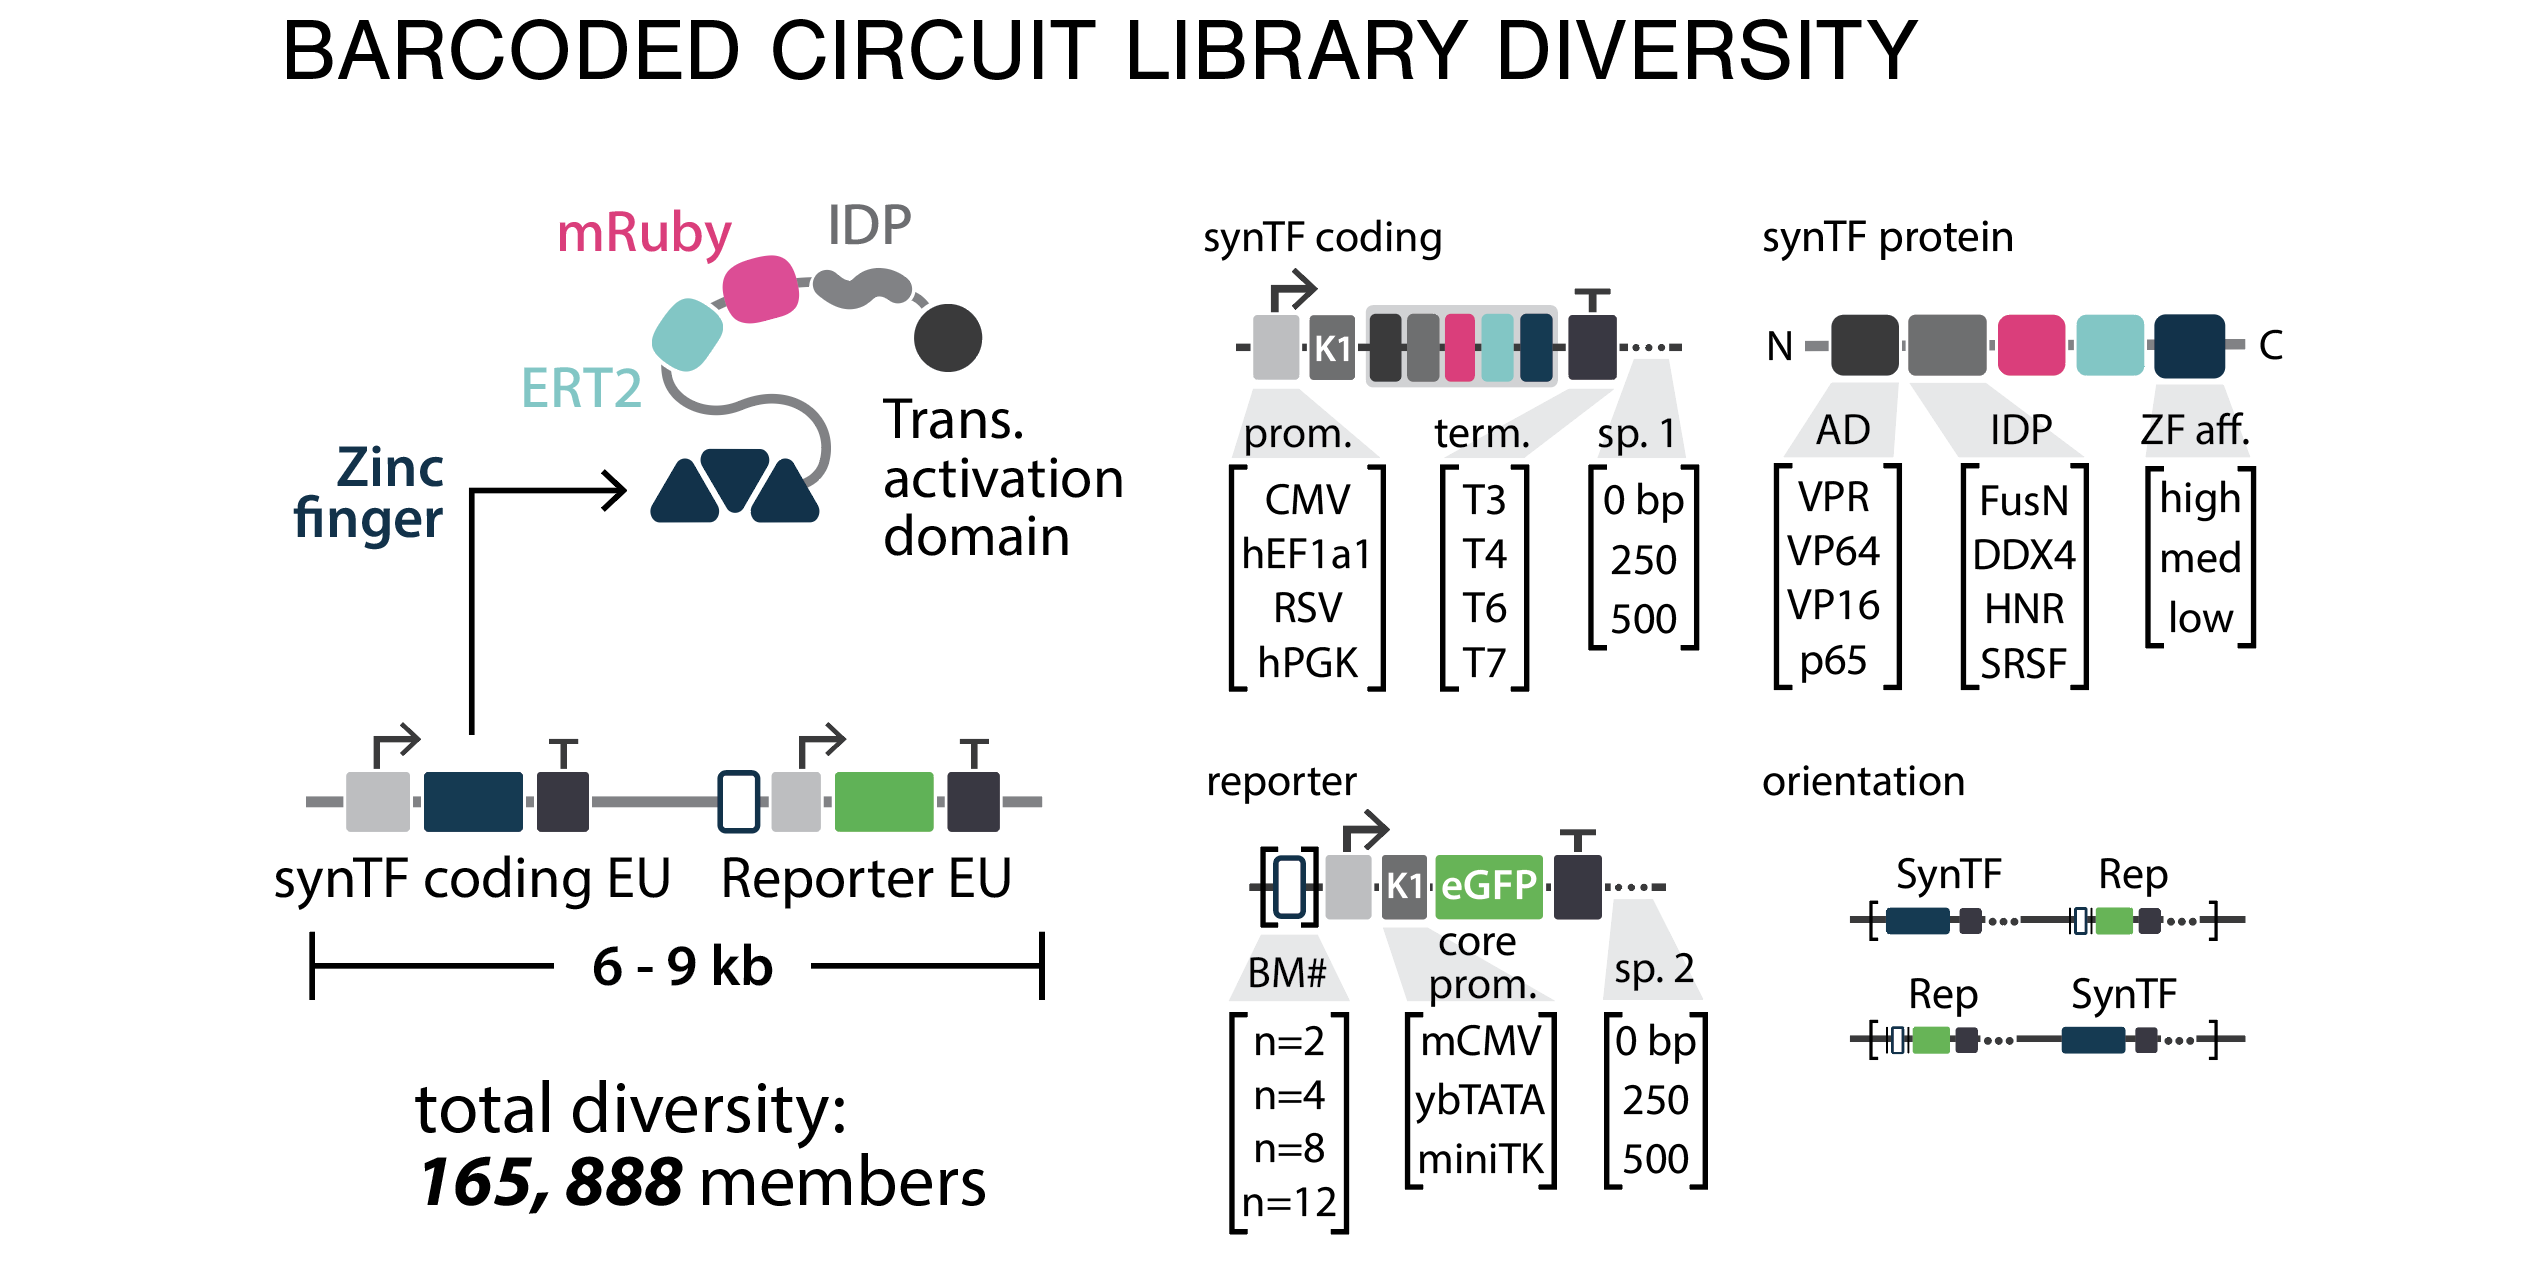

Each unit has multiple components that can vary, each chosen from one of several options (for example, promoter of SynTF unit can be CMV, hEF1a1, RSV, or hPGK).


## Loading input data and reference sequences

We have a number of constant sequences in this library that we will use as various points as "landmarks": constant regions surrounding regions of expected diversity, such as an A4 chromatin insulator upstream, and GFP downstream of the region where we expect our BM arrays, and minimal promoters to be.

These sequences are of variable sizes, ranging from ~200 bp (A4), to >700bp (GFP, mRuby etc). We start by loading in these reference sequences, and trimming them down to only retain ~100bp, which is enough for WIMPY to unambiguously identify them from the nanopore reads. Making the reference sequences smaller in size helps speed up the landmark identification steps we'll be doing downstream. So you can skip the trimming of the sequences, but note that the runtime to identify these in your reads will be longer if so.

Trimming the landmark sequences can be done from anywhere (beginning/middle/end of the read), but ideally you want to pick a region of the landmark sequence that is unambiguous and found uniquely in the read. In our example, all landmark sequences are unique, and we use a mix of trimming from the middle (e.g. with mRuby and BFP) and the end (e.g. - GFP, A4) for illustrative purposes.

In [3]:
# reference sequences from input fasta file
with open(r"../example_ref_sequences/ref_sequences.fasta") as ref_fasta_file:
    ref_seqs = {
        record.id: str(record.seq) for record in SeqIO.parse(ref_fasta_file, "fasta")
    }
    
Puro = ref_seqs['Puro']
GFP = ref_seqs['GFP'][-100:]
A4 = ref_seqs['A4'][-50:]
minP = ref_seqs['minP']
mRuby = ref_seqs['mRuby'][200:300]
BFP = ref_seqs['BFP'][200:300]
BS10_1 = ref_seqs['BS10_1']
ZF_parts = [ref_seqs['WT'], ref_seqs['C1_WT'], ref_seqs['C1_6x']]

# reference sequences from excel files
minP_100k = pd.read_excel(r'../example_ref_sequences/100k_Minimal-Promoters.xlsx')['Sequence'].to_list()
terminators_100k = pd.read_excel(r'../example_ref_sequences/100k_Terminators.xlsx')['Sequence'].to_list()
spacers_100k = pd.read_excel(r'../example_ref_sequences/100k_Terminator_spacers.xlsx')['Sequence'].to_list()
promoters_100k = pd.read_excel(r'../example_ref_sequences/100k-Promoters.xlsx')['Sequence'].to_list()
ORF_parts = pd.read_excel(r'../example_ref_sequences/100k_ORF-Parts_SynTF.xlsx')['SEQUENCE'].to_list()
AD_parts, IDR_parts = ORF_parts[0:4], ORF_parts[4:8]


## Step1: Consolidate reads with `fastqall`

We load the input Nanopore sequencing files with `fastqall`, and filter out all reads that are not within the expected size range (9500 to 15000 bp in this case):

In [4]:
# load in data
_, l, seqs = wp.fastqall('../example_fastq/', idx_end=1)
l, seqs = np.array(l), np.array(seqs)

# filter based on read length
seqs = seqs[(l > 9500) & (l < 15000)]
l = l[(l > 9500) & (l < 15000)]


reading fastq files:   0%|          | 0/1 [00:00<?, ?it/s]

## Step2: Orient reads and tether to reference sequence with `bowtile`

Initial aliment with `bowtile`. In this example, every read should contain a puromycin (`Puro`) resistance gene which is present directly upstream of all expected diversity in the library. Therefore, we use `Puro` as the anchor point and re-index all reads to start with `Puro`.

The fastq file from nanopore contains plasmids that are read both in forward and reverse-complement direction. The ones sequences in reverse are flipped by `bowtile` so the ouput is all in forward direction.

In [5]:
# bowtile for alignment
new_seq, _, _ = wp.bowtile(seqs, Puro, thresh=0.03)
new_seq = np.array(new_seq)

# filter out failed attempts
reads_correct = new_seq[new_seq != '']
l_reads_correct = l[new_seq != '']
num_seqs = len(reads_correct)

bowtile progress:   0%|          | 0/2452 [00:00<?, ?it/s]

## Step 3: Part Identification

This part of the script deals with part assignments in all variable regions. This is done via a combination of 3 steps, ie - 

1. Tilepin - to identify constant regions upstream and downstream of any given region of expected diversity.
2. Chophat - trim regions in between the identified landmarks, to create a truncated array that is expected to contain variable sequences, and
3. (A) Viscount - identify part assignment from a list of candidate parts that could be present in a given region (such as one of four possible promoters), or (B) Fastar - identify location and number of repeats for a given singular sequence (such as repeated arrays of a binding motif (BM) sequence)


### Locating key landmarks

Locate key landmark regions via `tilepin_v2` (an upgraded version of the original `tilepin`, which uses hashmap to improve performance. See bottom of the notebook for performance comparison). We use the index of these landmarks to help locate the varied regions with multiple parts.

`tilepin_v2` generates three outputs; 
1. The number of reference k-mers found in a read,
2. The median position of the reference k-mer, and
3. The indices of all k-mers found in the read

Since we only need the median location of these landmarks for truncation downstream, we discard the first and third outputs, and retain only the second. We do this for a number of landmark sequences that will be required for truncating different regions of expected diversity by `chophat` later on.

In [6]:
_, positions_GFP, _ = wp.tilepin_v2(reads_correct, GFP, thresh=0.03, verbose=True)
_, positions_mRuby, _ = wp.tilepin_v2(reads_correct, mRuby, thresh=0.03, verbose=True)
_, positions_A4, _ = wp.tilepin_v2(reads_correct, A4, thresh=0.03, verbose=True)
_, positions_minP, _ = wp.tilepin_v2(reads_correct, minP, thresh=0.03, verbose=True)
_, positions_BFP, _ = wp.tilepin_v2(reads_correct, BFP, thresh=0.03, verbose=True)

match sequences to reference:   0%|          | 0/2444 [00:00<?, ?it/s]

match sequences to reference:   0%|          | 0/2444 [00:00<?, ?it/s]

match sequences to reference:   0%|          | 0/2444 [00:00<?, ?it/s]

match sequences to reference:   0%|          | 0/2444 [00:00<?, ?it/s]

match sequences to reference:   0%|          | 0/2444 [00:00<?, ?it/s]

### Reporter Unit Identification

We start by identifying the parts within the repoter expression unit. To start, we cut out promoter and terminator regions with `chophat`, which truncate the sequence based on a starting landmark, and either a ending landmark or a max region length. In our example, we select:

- `p_regions`: promoter region, flanked between A4 chromatin insulator and GFP: contains the number of BM repeats, and minimal promoter
- `t_regions`: terminator region, starting with GFP and <= 2000 bp from it: contains the terminator spacer

In [7]:
# pregions and tregions using chophat
p_regions = wp.chophat(reads_correct, positions_A4, end_positions=positions_GFP)
t_regions = wp.chophat(reads_correct, positions_GFP, max_length=2000)

#### Assign minimal promoter

`p_regions` contains a minimal promoter, which can be one of the three variants (`minP_100k`). Here we use `viscount` to assign the read with its corresponding minimal promoter variant.

- since the sequence of minimal promoter is small, we use a smaller tile. This could increase the misassignment rate, as smaller tiles (k-mers) are more likely to be found in off-target regions by chance. As such, we increase the threshold for the proportion of k-mers required to be considered for a positive assignment, to accomodate for this higher likelihood of errors

In [8]:
thresh = 0.3
minP_match_ratios, _  = wp.viscount(
    p_regions,
    minP_100k,
    thresh,
    tile_len=6,
    verbose=True,
    return_confusion_matrix=False,
)
minP_variants = np.argmax(minP_match_ratios, axis=1)
minP_variants[np.sum(minP_match_ratios, axis=1) < thresh] = -1

#plt.figure(figsize=(4, 4))
#plt.imshow(conf)
#plt.colorbar()
#plt.show()

matching to reference sequences:   0%|          | 0/3 [00:00<?, ?it/s]

#### Assign number of binding sites using `fastar`

Using BS10_1 as a reference sequence in the `p_regions` array, we can find the number (and location, though that isn't needed in this example) of binding sites in every read. Since we know the reads can only contain 2, 4, 8 or 12 binding sites, we correct some of the assignments in bins nearby (such as 7 or 9 BMs instead of 8) to the appropriate number


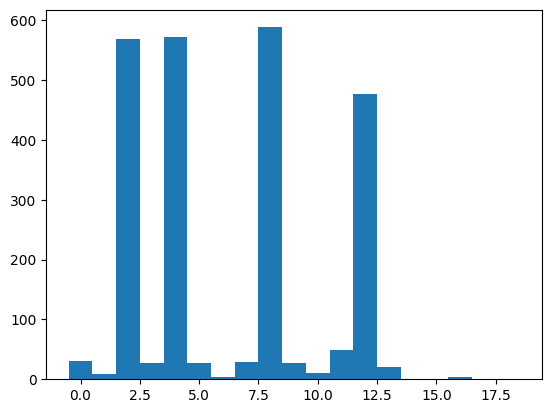

In [9]:
nbs, _ = wp.fastar(p_regions, BS10_1, tile_len=6, bw=8)
plt.hist(nbs, bins=np.arange(20)-0.5)

#Assign anything with 10 or more binding sites to 12, anything between 7 & 10 binding sites to 8, and anything between 4 & 6 to 4. All else go to 0 
nbs[nbs > 9.2] = 12
nbs[(nbs > 6.9) & (nbs < 10)] = 8
nbs[(nbs > 3.9) & (nbs < 6.1)] = 4
nbs[(nbs != 2) & (nbs != 4) & (nbs != 8) & (nbs != 12)] = -1

#Reassign the number of binding sites to 0, 1, 2, 3, and 4
value_map = {-1: -1, 2: 0, 4: 1, 8: 2, 12:3}
bs_variants = [value_map[x] for x in nbs]

#### Assign terminator spacing

Assign the terminator spacer variants with `viscount`, similar to assigning minimal promoter variants. Note that here "No spacing" is an option too. So we tile for the 250 and 500bp spacers, and if tiles for neither of the two are found, we assign it to 0, or no spacing

Another thing we have to be mindful of is the fact that the 500 bp spacer contains the 250bp spacer as well. As such, any read that contains the 500bp spacer will also have the entirety of the 250 bp spacer contained within it. Thus normalized counts, the typical output, cannot be used here, and instead we use non normalized counts, since the total number of counts in the 500 bp spacer will naturally be much higher than 250 (max possible number of 250bp spacer tiles)

In [11]:
_, term_spacer_counts = wp.viscount(t_regions, spacers_100k, 0.2, return_confusion_matrix=False, verbose=True)
term_spacer_variants = np.argmax(term_spacer_counts, axis=1) + 1
#Any reads where none of the columns had at least 20% of reference tiles belongs to "no spacer", or 0
term_spacer_variants[np.all(term_spacer_counts < 20, axis =1)] = 0

matching to reference sequences:   0%|          | 0/2 [00:00<?, ?it/s]

#### Combine the variant assignment for the reporter unit

Here we consolidate the number of BMs (bs_variants), the minimal promoter (minP_variants), and the terminator spacing (term_spacer_variants) into one nX3 array


In [12]:
reporter_variants = np.stack([bs_variants, minP_variants, term_spacer_variants]).T

### SynTF Unit Identification

Now we identify the parts in the SynTF unit, using a process similar to the one used to assign variants in the reporter unit. We start by using `chophat` to truncate regions based on indices identified earlier from `tilepin`, followed by `viscount` to assign variants

In [13]:
thresh = 0.03 #Kept low to increase sensitivity of assignments. Can raise if specificity is more desirable

# chophat to define promoter and terminator regions for synTFs
pregions_synTF = wp.chophat(reads_correct, np.zeros_like(positions_minP), positions_minP)
tregions_synTF = wp.chophat(reads_correct, positions=positions_mRuby, end_positions=positions_A4)

#### Assign promoter for SynTF unit

In [14]:
# viscount to find best match for synTFs
synTF_prom_match_ratios, _, synTF_prom_conf = wp.viscount(pregions_synTF, promoters_100k, thresh=thresh, verbose=True)
synTF_prom_variants = np.argmax(synTF_prom_match_ratios, axis=1)
synTF_prom_variants[np.sum(synTF_prom_match_ratios, axis=1) < thresh] = -1

matching to reference sequences:   0%|          | 0/4 [00:00<?, ?it/s]

#### Assign ORF parts - activation domain (AD)

For this part category, we deal with a particularly unique challenge - the entirety of the fourth AD is contained within the third AD (with AD 3 being much bigger in size). As such, when AD 3 is contained within a read, the normalized tiles for both AD 3 and AD 4 will read pretty high. Thus, to assign AD parts, we'll use the non normalized (absolute) tile counts from viscount.

matching to reference sequences:   0%|          | 0/4 [00:00<?, ?it/s]

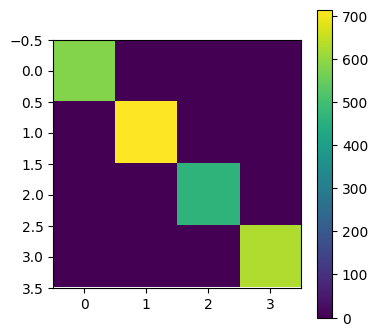

In [15]:
# viscount to find best match for ADs
_, AD_count, AD_conf = wp.viscount(pregions_synTF, AD_parts, thresh=0.2, verbose=True)
AD_count[AD_count < 30] = 0
AD_variants = np.argmax(AD_count, axis=1)
AD_variants[np.sum(AD_count, axis=1) == 0]

# Adjust values in the confusion matrix to reflect the change (optional, for visualization only)
AD_conf[3, 3] = np.sum((AD_count[:, 3] > 10) & (AD_count[:, 2] < 100))
AD_conf[2, 2] = np.sum(AD_count[:, 2] > 100)
AD_conf[2, 3] = np.sum((AD_count[:, 3] < 10) & (AD_count[:, 2] > 100))
AD_conf[3, 2] = AD_conf[2, 3]

# Visualize confusion matrix for activation domain assignment
plt.figure(figsize=(4, 4))
plt.imshow(AD_conf)
plt.colorbar()
plt.show()

#### Identify IDRs
Standard process of running `viscount` on the pregions_synTF variable, with a tile length of 10, slightly high threshold of 0.15 (because two of the IDRs are a little bit similar to each other)

matching to reference sequences:   0%|          | 0/4 [00:00<?, ?it/s]

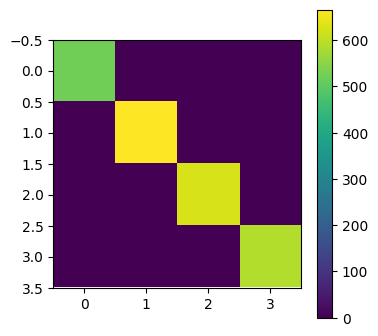

In [16]:
IDR_tiles, _, IDR_conf = wp.viscount(
    pregions_synTF, 
    IDR_parts, 
    tile_len=10, 
    thresh=0.15, 
    return_confusion_matrix=True, 
    verbose=True
)

IDR_variants = np.argmax(IDR_tiles, axis=1)

# visualize confusion matrix
plt.figure(figsize=(4, 4))
plt.imshow(IDR_conf)
plt.colorbar()
plt.show()

#### Identify zinc fingers

In [17]:
# Analyze Zinc Fingers
ZF_match_ratios, zfnn, ZF_conf = wp.viscount(
    tregions_synTF, ref_seqs=ZF_parts, thresh=0.3, tile_len=10, verbose=True
)

ZF_variants = np.argmax(ZF_match_ratios, axis=1)
ZF_variants[np.sum(ZF_match_ratios, axis=1) == 0] = -1

matching to reference sequences:   0%|          | 0/3 [00:00<?, ?it/s]

#### Identify terminators

matching to reference sequences:   0%|          | 0/4 [00:00<?, ?it/s]

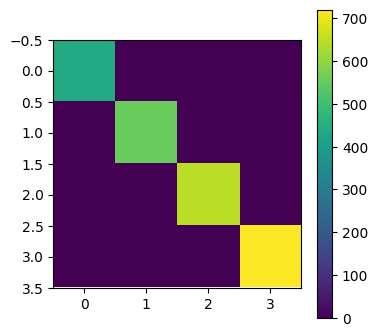

In [18]:
# Analyze terminators using viscount
term_synTF_match_ratios, _, term_synTF_conf = wp.viscount(
    tregions_synTF, 
    ref_seqs=terminators_100k, 
    thresh=0.4, 
    tile_len=10, 
    return_confusion_matrix=True, 
    verbose=True
)

term_synTF_variants = np.argmax(term_synTF_match_ratios, axis=1)

plt.figure(figsize=(4, 4))
plt.imshow(term_synTF_conf)
plt.colorbar()
plt.show()

#### Identify spacers

Similar to the spacers in the reporter unit, "No spacing" is an option too. So we tile for the 250 and 500bp spacers, and if tiles for neither of the two are found, we assign it to 0, or no spacing

matching to reference sequences:   0%|          | 0/2 [00:00<?, ?it/s]

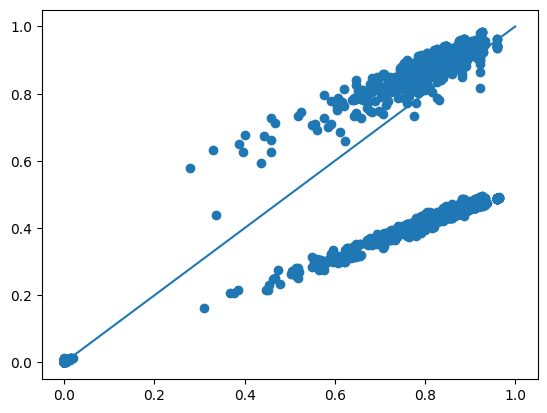

In [19]:
# Analyze terminators using viscount
spacer_ratios, spacer_nn = wp.viscount(
    tregions_synTF, 
    ref_seqs=spacers_100k, 
    thresh=0.4, 
    tile_len=10, 
    return_confusion_matrix=False, 
    verbose=True
)

synTF_spacer_variants = np.zeros(len(spacer_ratios))
synTF_spacer_variants[(spacer_ratios[:, 0] > 0.4) & (spacer_nn[:, 1] < 300)] = 0
synTF_spacer_variants[spacer_nn[:, 1] > 300] = 1

#synTF_spacer_variants = np.argmax(spacer_ratios, axis=1) + 1
#Any reads where none of the columns had at least 20% of reference tiles belongs to "no spacer", or 0
#synTF_spacer_variants[np.all(spacer_ratios < 20, axis =1)] = 0

#spacer_match_ratios[spacer_match_ratios < 0.2] = 0
#spacer_variants = np.argmax(spacer_match_ratios, axis=1)
plt.scatter(spacer_ratios[:, 0], spacer_ratios[:, 1])
plt.plot([0, 1], [0, 1])

#### Combine the variant assignment for the SynTF unit

In [20]:
# Calculate assignments for synTF variants
synTF_variants = np.stack([
    synTF_prom_variants,
    AD_variants,
    IDR_variants,
    ZF_variants,
    term_synTF_variants,
    synTF_spacer_variants
]).T


### Identify orientation

In [21]:
orientation_variants = np.zeros((num_seqs, 1))
orientation_variants[positions_GFP < positions_mRuby, 0] = 1


### Collect variant assignment, and give each read with a unique ID 

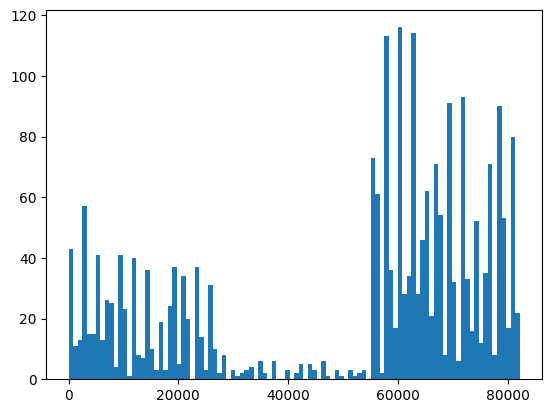

In [22]:
all_100k_variants = np.concatenate(
    [synTF_variants, reporter_variants, orientation_variants], axis=1
)
library_100k = (
    all_100k_variants @ np.array([1, 4, 16, 64, 192, 768, 2304, 9216, 27648, 82944]).T
)  #! check this
library_100k[np.any(all_100k_variants < 0, axis=1)] = -1

# visualize library balance
plt.figure()
plt.hist(library_100k[library_100k >= 0], bins=100)
plt.show()

## Barcoding & Barcoded AssTable Generation

In [23]:
# using barcoat function
tregion_BFP = wp.chophat(reads_correct, positions_BFP, max_length=1000, retain=True)

# BBA barcode
bba_barcode, bba_position, bba_length, bba_score = wp.barcoat(
    tregion_BFP, preset="BBA"
)

# DDC barcode
ddc_barcode, ddc_position, ddc_length, ddc_score = wp.barcoat(
    tregion_BFP, preset="DDC"
)

searching barcode using alignment:   0%|          | 0/2444 [00:00<?, ?it/s]

searching barcode using alignment:   0%|          | 0/2444 [00:00<?, ?it/s]

### Data Quality Control

Now all sequences are assigned with a barcode and variants for all parts. To create the final assignment table, we only keep the sequences with all the parts identified and barcodes aligned with a high enough score.

In [24]:
is_valid_alignment = (bba_score > 85) & (ddc_score > 90)
is_fully_assigned = (library_100k >= 0)

bba_correct = bba_barcode[is_valid_alignment & is_fully_assigned]
ddc_correct = ddc_barcode[is_valid_alignment & is_fully_assigned]
barcoded_variants = all_100k_variants[is_valid_alignment & is_fully_assigned]


In [25]:
barcoded_variants.shape

(1661, 10)

Congratulations! You have now created an assignment table for the library.

End of tutorial

-------------------------

**Performance comparision** (benchmark machine: Apple M1 Macbook Air):
- MatLab version of `tilepin()`
  - 15 s for the last 100 bp of GFP reference sequence
  - 2 min for whole GFP reference sequence
- `wp.tilepin()`
  - 15 s for the last 100 bp of GFP reference sequence
  - 6 min for whole GFP reference sequence
- `wp.tilepin_v2()`
  - 15 s for the last 100 bp of GFP reference sequence
  - 18 s for whole GFP reference sequence


/tmp/ipykernel_424561/7795323.py:1: DeprecationWarning: tilepin will be deprecated soon, please use tilepin_v2 instead. tilepin_v2 is faster and more efficient.
  _, positionsGFP1, _ = wp.tilepin(reads_correct, GFP, thresh=0.03, verbose=True)


tilepinning progress:   0%|          | 0/2444 [00:00<?, ?it/s]

match sequences to reference:   0%|          | 0/2444 [00:00<?, ?it/s]

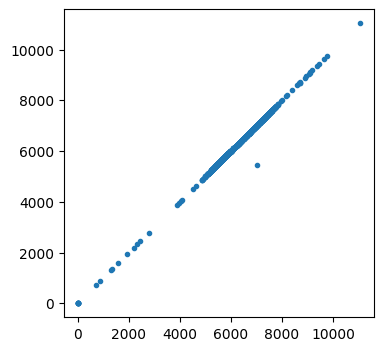

In [ ]:
_, positionsGFP1, _ = wp.tilepin(reads_correct, GFP, thresh=0.03, verbose=True)
_, positionsGFP2, _ = wp.tilepin_v2(reads_correct, GFP, thresh=0.03, verbose=True)
plt.figure(figsize=(4, 4))
plt.plot(positionsGFP1, positionsGFP2, '.')
plt.show()
